# Prueba Modelo con Data Augmentacion:
- Proceso de lectura a través de TF.
- Adicional se vuelve a tomar la parte de la lectura de los CTs una sola vez.

# Modelo.
- Limitación pixeles de -1000 a 0
- Prueba ventana parénquima pulmonar desde W3. Para ver si hay algo raro en el script.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!pip install volumentations-3D
# !pip install keras-tuner --upgrade
# !pip install keras_applications
# !pip install tensorflow==2.11.0
# !pip install keras==2.11.0
!pip install tensorflow-probability

In [ ]:
!pip list | grep tensorflow #tensorflow: 2.14.0, tensorflow-probability: 0.22.0

tensorflow                       2.14.0
tensorflow-datasets              4.9.3
tensorflow-estimator             2.14.0
tensorflow-gcs-config            2.14.0
tensorflow-hub                   0.15.0
tensorflow-io-gcs-filesystem     0.34.0
tensorflow-metadata              1.14.0
tensorflow-probability           0.22.0


In [ ]:
# Tratamiento datos
import pandas as pd
import numpy as np
from collections import Counter
import time

# Organizar rutas imágenes
import os
import random

# Lectura tomografías.
import nibabel as nib # Lectura
from scipy import ndimage # Tratamiento

# Modelado
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_probability as tfp
tfd = tfp.distributions

# Data Augmentation
from volumentations import *

# Visualización CTs
import matplotlib.pyplot as plt
import re

import itertools
from functools import partial

pd.set_option('display.max_columns', 500)
pd.set_option('display.float_format', lambda x: f'{x:.3f}')
#pd.set_option('display.float_format', lambda x: f'{x:,.3f}') #add a comma separator between the thousands.
pd.set_option('display.max_colwidth',1000)



np.set_printoptions(threshold=1000, linewidth = 300, edgeitems = 5)
np.set_printoptions(suppress=True)


import pickle

In [ ]:
import os
print("Ruta: ",os.getcwd())
print("Directorios: ",os.listdir())
os.chdir(r'/content/gdrive/MyDrive/Maestria/Tesis/Bayesian_NN/Code/tf_mnf/tf-mnf')
print("Ruta: ",os.getcwd())

Ruta:  /content
Directorios:  ['.config', 'gdrive', 'sample_data']
Ruta:  /content/gdrive/MyDrive/Maestria/Tesis/Bayesian_NN/Code/tf_mnf/tf-mnf


In [ ]:
from tf_mnf.layers import MNFDense

In [ ]:
os.chdir(r'/content')
print("Ruta: ",os.getcwd())
print("Directorios: ",os.listdir())

Ruta:  /content
Directorios:  ['.config', 'gdrive', 'sample_data']


# Parámetros

In [ ]:
ambiente = 'GOOGLE' # 'GOOGLE' o 'LOCAL'
reading_cts_tf = False
version_modelo = "Keras_Arch_3D_W4_V1_Uncertainty_V4" # CAMBIAR!!!!!!!!!!!!!!!!!!!!!!!!!!

# Ventana Parénquima Pulmonar
min_ventana = -1000
max_ventana = 0

# Rutas Datasets
ruta_dfs_google = r'/content/gdrive/MyDrive/Maestria/Tesis/Bayesian_NN/Data/Path_Sets/'
ruta_dfs_local = r'G:/Mi unidad/Maestria/Tesis/Bayesian_NN/Data/Path_Sets/'

ruta_modelo_google = r'/content/gdrive/MyDrive/Maestria/Tesis/Bayesian_NN/Modelos_Colab/'
ruta_modelo_local = r'G:/Mi unidad/Maestria/Tesis/Bayesian_NN/Modelos/'

# Rutas
if ambiente == 'GOOGLE':
    print("Rutas DFs")
    ruta_dfs = ruta_dfs_google

    print("El modelo se guardará en Modelos_Colab")
    ruta_modelo = ruta_modelo_google
    file_modelo = r'{}Modelo_{}.h5'.format(ruta_modelo_google,version_modelo)
    file_history = r'{}History_Modelo_{}'.format(ruta_modelo_google,version_modelo)

else:
    print("Rutas DFs")
    ruta_dfs = ruta_dfs_local

    print("El modelo se guardará en Modelos")
    ruta_modelo = ruta_modelo_local
    file_modelo = r'{}Modelo_{}.h5'.format(ruta_modelo_local,version_modelo)
    file_history = r'{}History_Modelo_{}'.format(ruta_modelo_local,version_modelo)

# Validando rutas
if os.path.exists(ruta_modelo):
    print("Existe ruta guardado modelo.")
    print(f"El modelo se guardará en: {file_modelo}")
else:
    print("Creando ruta para modelos!!!!!!! ")
    os.makedirs(ruta_modelo)

print(ruta_modelo)

# Parámetros Redes:
BATCH_SIZE=2
RANDOM = 9411
initial_learning_rate = 0.001
epochs = 150

Rutas DFs
El modelo se guardará en Modelos_Colab
Existe ruta guardado modelo.
El modelo se guardará en: /content/gdrive/MyDrive/Maestria/Tesis/Bayesian_NN/Modelos_Colab/Modelo_Keras_Arch_3D_W4_V1_Uncertainty_V4.h5
/content/gdrive/MyDrive/Maestria/Tesis/Bayesian_NN/Modelos_Colab/


# Lectura Imágenes

## Rutas

In [ ]:
if ambiente == 'GOOGLE':
    print("Leyendo rutas de google")
    train_df = pd.read_csv(ruta_dfs + 'train_df.csv')
    test_df = pd.read_csv(ruta_dfs + 'test_df.csv')
    valid_df = pd.read_csv(ruta_dfs + 'valid_df.csv')

    train_df['path'] = train_df['File_Path_Google']
    test_df['path'] = test_df['File_Path_Google']
    valid_df['path'] = valid_df['File_Path_Google']

else:
    print("Leyendo rutas del local")
    train_df = pd.read_csv(ruta_dfs + 'train_df.csv')
    test_df = pd.read_csv(ruta_dfs + 'test_df.csv')
    valid_df = pd.read_csv(ruta_dfs + 'valid_df.csv')

    train_df['path'] = train_df['File_Path']
    test_df['path'] = test_df['File_Path']
    valid_df['path'] = valid_df['File_Path']


Leyendo rutas de google


In [ ]:
# train_df = pd.DataFrame({'path' : ['/content/data/study_0001.nii.gz',
#                                    '/content/data/study_0002.nii.gz',
#                                    '/content/data/study_0003.nii.gz',
#                                    '/content/data/study_0004.nii.gz']})
# train_df['Label'] = 0

# valid_df = pd.DataFrame({'path' : ['/content/data/study_0003.nii.gz',
#                                    '/content/data/study_0004.nii.gz',
#                                    '/content/data/study_0005.nii.gz']})
# valid_df['Label'] = 0

# test_df = valid_df.copy()


# train_df

In [ ]:
valid_df.head()

,File_Path,File_Path_Google,Label,path
0,G:/Mi unidad/Maestria/Tesis/Bayesian_NN/Data/Real/CT-0/study_0026.nii.gz,/content/gdrive/MyDrive/Maestria/Tesis/Bayesian_NN/Data/Real/CT-0/study_0026.nii.gz,0,/content/gdrive/MyDrive/Maestria/Tesis/Bayesian_NN/Data/Real/CT-0/study_0026.nii.gz
1,G:/Mi unidad/Maestria/Tesis/Bayesian_NN/Data/Real/CT-0/study_0031.nii.gz,/content/gdrive/MyDrive/Maestria/Tesis/Bayesian_NN/Data/Real/CT-0/study_0031.nii.gz,0,/content/gdrive/MyDrive/Maestria/Tesis/Bayesian_NN/Data/Real/CT-0/study_0031.nii.gz
2,G:/Mi unidad/Maestria/Tesis/Bayesian_NN/Data/Real/CT-0/study_0180.nii.gz,/content/gdrive/MyDrive/Maestria/Tesis/Bayesian_NN/Data/Real/CT-0/study_0180.nii.gz,0,/content/gdrive/MyDrive/Maestria/Tesis/Bayesian_NN/Data/Real/CT-0/study_0180.nii.gz
3,G:/Mi unidad/Maestria/Tesis/Bayesian_NN/Data/Real/CT-0/study_0075.nii.gz,/content/gdrive/MyDrive/Maestria/Tesis/Bayesian_NN/Data/Real/CT-0/study_0075.nii.gz,0,/content/gdrive/MyDrive/Maestria/Tesis/Bayesian_NN/Data/Real/CT-0/study_0075.nii.gz
4,G:/Mi unidad/Maestria/Tesis/Bayesian_NN/Data/Real/CT-0/study_0139.nii.gz,/content/gdrive/MyDrive/Maestria/Tesis/Bayesian_NN/Data/Real/CT-0/study_0139.nii.gz,0,/content/gdrive/MyDrive/Maestria/Tesis/Bayesian_NN/Data/Real/CT-0/study_0139.nii.gz


## Lectura:

In [ ]:
def read_nifti_file(filepath):
    """Read and load volume"""
    # Read file
    scan = nib.load(filepath)
    # Get raw data
    scan = scan.get_fdata(caching='unchanged')
    return scan


def normalize(volume, min_normalize, max_normalize):
    """Normalize the volume"""
    min = min_normalize #-1000
    max = max_normalize #400
    volume[volume < min] = min
    volume[volume > max] = max
    volume = (volume - min) / (max - min)
    volume = volume.astype("float32")
    return volume


def resize_volume(img):
    """Resize across z-axis"""
    # Set the desired depth
    desired_depth = 64
    desired_width = 128
    desired_height = 128
    # Get current depth
    current_depth = img.shape[-1]
    current_width = img.shape[0]
    current_height = img.shape[1]
    # Compute depth factor
    depth = current_depth / desired_depth
    width = current_width / desired_width
    height = current_height / desired_height
    depth_factor = 1 / depth
    width_factor = 1 / width
    height_factor = 1 / height

    # Resize across z-axis
    tic = time.time()
    img = ndimage.zoom(img, (width_factor, height_factor, depth_factor), order=1)
    #print("     Tiempo zoom:",time.time() - tic)

    # Rotate
    tic = time.time()
    img = ndimage.rotate(img, 90, reshape=False)
    #print("     Tiempo rotate:",time.time() - tic)

    return img

In [ ]:
def rotate(volume):
    # define some rotation angles
    angles = [-20, -10, -5, 5, 10, 20]
    # pick angles at random
    angle = random.choice(angles)
    # rotate volume
    volume = ndimage.rotate(volume, angle, reshape=False)
    volume[volume < 0] = 0
    volume[volume > 1] = 1
    return volume

In [ ]:
def get_augmentation(patch_size):
    return Compose([
        #Resize(patch_size, interpolation=1, resize_type=0, always_apply=True, p=1.0),
        Flip(0, p=1), # Eje X
        Flip(1, p=1), # Eje Y
        Flip(2, p=1), # Eje Z
        GaussianNoise(var_limit=(0.0001, 0.0005), p=1),
        ColorJitter(brightness=(1,3),contrast=(0.4,0.8),saturation=0,hue=0, p=1),
    ], p=1)

def augmentor(img):
    aug = get_augmentation((128,128,64))
    data = {'image': img}
    aug_data = aug(**data)
    img = aug_data['image']
    return np.ndarray.astype(img , np.float32)



In [ ]:
def load_arrays(path, training_):

    #print(path.numpy().decode())
    tic1 = time.time()

    # Lectura CT
    tic = time.time()
    image_ = nib.load(path.numpy().decode())
    #print("Tiempo lectura:",time.time() - tic)

    # Convertirlo en array
    tic = time.time()
    image_ = image_.get_fdata()
    #print("shape:",image_.shape)
    #print("Tiempo array:",time.time() - tic)

    # Aplicar función de estandarización número de cortes y rotación 90 grados
    tic = time.time()
    image = resize_volume(image_)[..., None]
    #print("Tiempo resize:",time.time() - tic)

    # Aplicar función normalización
    tic = time.time()
    image = normalize(image, min_normalize=min_ventana, max_normalize=max_ventana)
    #print("Tiempo normalizacion:",time.time() - tic)

    if training_:
        #print("Aplicando Data Augmentation************************************")

        # Aplicar rotación aleatoria
        tic = time.time()
        image = rotate(image)
        #print("Tiempo rotación aleatoria:",time.time() - tic)

        # Implementar data augmentation
        tic = time.time()
        #image = augmentor(image)
        #print("Tiempo aug:",time.time() - tic)

        # Limitando valores entre 0-1
        tic = time.time()
        #image = tf.clip_by_value(image, clip_value_min = 0, clip_value_max = 1)
        #print("Tiempo clip_by_value:",time.time() - tic)

    else:
        #print("Las tomografías se cargan solo con el resize y la normalización")

        #print("|| Tiempo total lectura tomografía: ", time.time() - tic1)
        #print("---")

        image = image


    return image#.reshape(image_.shape+(1,))

def tf_data_array(filenames1, labels, training_):
    [image,] = tf.py_function(func= load_arrays,  inp=[filenames1, training_], Tout=[tf.float32])
    image.set_shape((128,128,64,1))
    return image,  labels

In [ ]:
def datasets_iteration(dataset_row, training=False):
    filename = dataset_row['path']
    labels = dataset_row['Label']
    dataset = tf.data.Dataset.from_tensor_slices((filename,labels))

    #print(dataset)

    if training:
        dataset = dataset.shuffle(len(dataset_row),seed=RANDOM)

    #Aplicamos todas las funciones de pre-procesamiento
    #dataset = dataset.map(tf_data_array).batch(BATCH_SIZE)#.prefetch(tf.data.AUTOTUNE)
    # dataset = dataset.map(tf_data_array).cache().batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    # dataset = dataset.map(tf_data_array, num_parallel_calls = 4).batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)
    # dataset = dataset.map(tf_data_array, num_parallel_calls = 4).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    # dataset = dataset.map(tf_data_array, num_parallel_calls = 4).batch(BATCH_SIZE).prefetch(1)
    dataset = dataset.map(partial(tf_data_array, training_ = training), num_parallel_calls = tf.data.AUTOTUNE).batch(BATCH_SIZE).prefetch(2)

    # https://stackoverflow.com/questions/59228816/what-do-the-tensorflow-datasets-functions-cache-and-prefetch-do
    # https://stackoverflow.com/questions/63796936/what-is-the-proper-use-of-tensorflow-dataset-prefetch-and-cache-options
    # https://cs230.stanford.edu/blog/datapipeline/#best-practices
    return dataset

In [ ]:
train_dataset = datasets_iteration(train_df,True)
test_dataset = datasets_iteration(test_df)
validation_dataset = datasets_iteration(valid_df)

# train_dataset = datasets_iteration(train_df.iloc[[5,6,7,8,9,290,291,292,293,294]],True)
# test_dataset = datasets_iteration(test_df.iloc[[5,6,7,8,9,79,80,81,82,83]])
# validation_dataset = datasets_iteration(valid_df.iloc[[5,6,7,8,9,40,41,42,43,44]])

In [ ]:
validation_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 64, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

### Método una sola lectura

In [ ]:
def process_scan(path, min_normalize, max_normalize):
    """Read and resize volume"""
    # Read scan
    volume = read_nifti_file(path)
    # Resize width, height and depth
    volume = resize_volume(volume)[..., None]
    # Normalize
    volume = normalize(volume, min_normalize=min_normalize, max_normalize=max_normalize)

    return volume

def data_augmentation(volume, training_):

    if training_:

        #print("Aplicando Data Augmentation************************************")

        # Aplicar rotación aleatoria
        tic = time.time()
        volume = rotate(volume)
        #print("Tiempo rotación aleatoria:",time.time() - tic)

        # Implementar data augmentation
        tic = time.time()
        # volume = augmentor(volume)
        #print("Tiempo aug:",time.time() - tic)

        # Limitando valores entre 0-1
        tic = time.time()
        # volume = tf.clip_by_value(volume, clip_value_min = 0, clip_value_max = 1)
        #print("Tiempo clip_by_value:",time.time() - tic)

    else:
        volume = volume

    return volume


def tf_data_array2(images, labels, training_):
    [image,] = tf.py_function(func= data_augmentation,  inp=[images, training_], Tout=[tf.float32])
    image.set_shape((128,128,64,1))
    return image,  labels



In [ ]:
if reading_cts_tf == False:
  print("Leyendo CTs una sola vez")
  # Leyendo tomografías de entrenamiento
  print("Leyendo tomografías de entrenamiento")
  tic = time.time()
  x_train = np.array([process_scan(path, min_normalize= min_ventana, max_normalize=max_ventana) for path in train_df['path']])
  print("--- %s minutos ---" % ((time.time() - tic)/60))

  print("Leyendo tomografías de test")
  tic = time.time()
  x_test = np.array([process_scan(path, min_normalize= min_ventana, max_normalize=max_ventana) for path in test_df['path']])
  print("--- %s minutos ---" % ((time.time() - tic)/60))

  print("Leyendo tomografías de validación")
  tic = time.time()
  x_valid = np.array([process_scan(path, min_normalize= min_ventana, max_normalize=max_ventana) for path in valid_df['path']])
  print("--- %s minutos ---" % ((time.time() - tic)/60))


Leyendo CTs una sola vez
Leyendo tomografías de entrenamiento
--- 15.565547327200571 minutos ---
Leyendo tomografías de test
--- 4.143216121196747 minutos ---
Leyendo tomografías de validación
--- 2.0527549982070923 minutos ---


In [ ]:
# Validación Dimensión Arrays:
print(f"Dim x_train: {x_train.shape} -- Dim y_train: {len(train_df['path'])}. -- {Counter(train_df['Label'])}")
print(f"Dim x_train: {x_test.shape} -- Dim y_train: {len(test_df['path'])}. -- {Counter(test_df['Label'])}")
print(f"Dim x_train: {x_valid.shape} -- Dim y_train: {len(valid_df['path'])}. -- {Counter(valid_df['Label'])}")

Dim x_train: (295, 128, 128, 64, 1) -- Dim y_train: 295. -- Counter({0: 177, 1: 118})
Dim x_train: (84, 128, 128, 64, 1) -- Dim y_train: 84. -- Counter({0: 50, 1: 34})
Dim x_train: (45, 128, 128, 64, 1) -- Dim y_train: 45. -- Counter({0: 27, 1: 18})


In [ ]:
def datasets_iteration2(images, dataset_row, training=False):

    labels = dataset_row['Label']

    dataset = tf.data.Dataset.from_tensor_slices((images,labels))

    if training:
        dataset = dataset.shuffle(len(images),seed=RANDOM)

    dataset = dataset.map(partial(tf_data_array2, training_ = training), num_parallel_calls = tf.data.AUTOTUNE).batch(BATCH_SIZE)#.prefetch(1)

    #dataset = dataset.batch(BATCH_SIZE).prefetch(2)

    return dataset


In [ ]:
if reading_cts_tf == False:
  print("Datasets creados con datasets_iteration2 ************")
  train_dataset = datasets_iteration2(x_train, train_df,True)
  test_dataset = datasets_iteration2(x_test, test_df)
  validation_dataset = datasets_iteration2(x_valid, valid_df)
else:
  print("Se mantiene el objeto TF para lectura de CTs según el batch")

Datasets creados con datasets_iteration2 ************


In [ ]:
validation_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 64, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

## Visualizamos algunas imágenes

### Train

In [ ]:
tic = time.time()
data = train_dataset.take(1) # Tomamos primer batch
data2 = list(data)

images, labels = data2[0]
images = images.numpy()
print("******* Tiempo total lectura batch: ", time.time() - tic)


******* Tiempo total lectura batch:  1.4735112190246582


In [ ]:
index_ct = 0
mensaje = f"CT Etiqueta: {labels.numpy()[index_ct]} "
print(mensaje)
img_print = images[index_ct]
label_print = labels.numpy()[index_ct]
fig = plt.figure(figsize=(30, 20))
columns = 10
rows = 7
depth_img = img_print.shape[2]

file_image_path = f'G:/Mi unidad/Maestria/Tesis/Bayesian_NN/Data/Imgs/TF_VF_Index{index_ct}_Rango{min_ventana}_{max_ventana}.png'
print(file_image_path)


# ax enables access to manipulate each of subplots
ax = []

for i in range(1, depth_img+1):
    img = np.squeeze(img_print[:, :, i-1])
    #fig.add_subplot(rows, columns, i)
    ax.append( fig.add_subplot(rows, columns, i))
    ax[-1].set_title("depth:"+str(i))  # set title
    plt.imshow(img, cmap='gray')
plt.suptitle(mensaje)
#plt.savefig(file_image_path)
plt.show()

Output hidden; open in https://colab.research.google.com to view.

### Valid

In [ ]:
tic = time.time()
data = validation_dataset.take(1) # Tomamos primer batch
data2 = list(data)

images, labels = data2[0]
images = images.numpy()
print("******* Tiempo total lectura batch: ", time.time() - tic)


******* Tiempo total lectura batch:  0.1382613182067871


In [ ]:
index_ct = 0
mensaje = f"CT Etiqueta: {labels.numpy()[index_ct]} "
print(mensaje)
img_print = images[index_ct]
label_print = labels.numpy()[index_ct]
fig = plt.figure(figsize=(30, 20))
columns = 10
rows = 7
depth_img = img_print.shape[2]

file_image_path = f'G:/Mi unidad/Maestria/Tesis/Bayesian_NN/Data/Imgs/TF_VF_Index{index_ct}_Rango{min_ventana}_{max_ventana}.png'
print(file_image_path)


# ax enables access to manipulate each of subplots
ax = []

for i in range(1, depth_img+1):
    img = np.squeeze(img_print[:, :, i-1])
    #fig.add_subplot(rows, columns, i)
    ax.append( fig.add_subplot(rows, columns, i))
    ax[-1].set_title("depth:"+str(i))  # set title
    plt.imshow(img, cmap='gray')
plt.suptitle(mensaje)
#plt.savefig(file_image_path)
plt.show()

Output hidden; open in https://colab.research.google.com to view.

# Modelo 1 - Data Augmentation Keras

In [ ]:
def get_model(width=128, height=128, depth=64):
    """Build a 3D convolutional neural network model."""

    inputs = keras.Input((width, height, depth, 1))

    x = layers.Conv3D(filters=128, kernel_size=3, activation="relu")(inputs)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=128, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=256, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=512, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.GlobalMaxPooling3D()(x)
    x = layers.Dense(units=256, activation="relu")(x)
    x = layers.Dropout(0.2)(x)

    # Opción 1 - A
    # x = layers.Dense(units=tfp.layers.IndependentBernoulli.params_size(1))(x)
    # outputs = tfp.layers.IndependentBernoulli(1)(x)

    # Opción 1 - B
    # x = layers.Dense(units=tfp.layers.IndependentBernoulli.params_size(1))(x)
    # outputs = tfp.layers.IndependentBernoulli(1, tfd.Bernoulli.mean)(x)

    # Opcion 2 - A
    # x = MNFDense(tfp.layers.IndependentBernoulli.params_size(1))(x)
    # outputs = tfp.layers.IndependentBernoulli(1)(x) # tfd.Bernoulli.mean

    # Opcion 2 - B
    x = MNFDense(tfp.layers.IndependentBernoulli.params_size(1))(x)
    outputs = tfp.layers.IndependentBernoulli(1, tfd.Bernoulli.mean)(x) # tfd.Bernoulli.mean

    # Define the model.
    model = keras.Model(inputs, outputs, name="3dcnn")
    return model


# Build model.
model = get_model(width=128, height=128, depth=64)
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


Model: "3dcnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 64, 1   0         
                             )]                                  
                                                                 
 conv3d (Conv3D)             (None, 126, 126, 62, 12   3584      
                             8)                                  
                                                                 
 max_pooling3d (MaxPooling3  (None, 63, 63, 31, 128)   0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 63, 63, 31, 128)   512       
 Normalization)                                                  
                                                                 
 conv3d_1 (Conv3D)           (None, 61, 61, 29, 128)   442496

In [ ]:
def nll(y_true, y_pred):
    return -y_pred.log_prob(y_true)

len_train = len(train_dataset) # Originalmente se había ejecutado con len(train_df['path'])
print(len_train)
def kl_loss(y_true, y_predict):
  nll_ = nll(y_true, y_predict)
  kl = model.layers[-2].kl_div() / len_train
  return kl + nll_

In [ ]:
os.getcwd()

'/content'

In [ ]:
if os.path.isfile(file_modelo):
  print(f"Ruta modelo existe!!!!!!!!!!!!!!!!!!!!!!!!!!!! {file_modelo}")
else:
  print(f"Se creará archivo: {file_modelo}")

Se creará archivo: /content/gdrive/MyDrive/Maestria/Tesis/Bayesian_NN/Modelos_Colab/Modelo_Keras_Arch_3D_W4_V1_Uncertainty_V4.h5


## Compilar Modelo

In [ ]:
tic = time.time()
# Compile model.
# initial_learning_rate = 0.0001
# lr_schedule = keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
# )

# reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min' ,factor=0.8,verbose=1,
#                               patience=5, min_lr=1e-6)

# model.compile(
#     loss="binary_crossentropy",
#     optimizer=keras.optimizers.Adam(learning_rate=initial_learning_rate),
#     metrics=["acc"],
# )

model.compile(
    loss= kl_loss, # Si es opción 2: kl_loss
    optimizer=keras.optimizers.Adam(learning_rate=initial_learning_rate),
    metrics=["acc"],
)

# Define callbacks.
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    file_modelo,
    save_best_only=True, monitor = "val_loss", mode = "min", save_weights_only = True, verbose = 1,
)
early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_loss", mode = 'min', restore_best_weights = True, patience=15, verbose = 1)

# Train the model, doing validation at the end of each epoch
# epochs = 100
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    verbose=2,
    # callbacks=[checkpoint_cb, early_stopping_cb], #reduce_lr],
)
print("******* Tiempo total entrenamiento en minutos: ", (time.time() - tic)/60)

Epoch 1/150
148/148 - 82s - loss: 10.7455 - acc: 0.5831 - val_loss: 9.9418 - val_acc: 0.4000 - 82s/epoch - 555ms/step
Epoch 2/150
148/148 - 58s - loss: 9.6444 - acc: 0.5932 - val_loss: 9.4929 - val_acc: 0.4000 - 58s/epoch - 391ms/step
Epoch 3/150
148/148 - 58s - loss: 9.2472 - acc: 0.6237 - val_loss: 9.2010 - val_acc: 0.6000 - 58s/epoch - 391ms/step
Epoch 4/150
148/148 - 58s - loss: 8.8764 - acc: 0.6847 - val_loss: 8.9976 - val_acc: 0.6444 - 58s/epoch - 391ms/step
Epoch 5/150
148/148 - 58s - loss: 8.6707 - acc: 0.6949 - val_loss: 8.6759 - val_acc: 0.6444 - 58s/epoch - 390ms/step
Epoch 6/150
148/148 - 58s - loss: 8.3141 - acc: 0.7322 - val_loss: 8.4365 - val_acc: 0.6222 - 58s/epoch - 390ms/step
Epoch 7/150
148/148 - 58s - loss: 7.9901 - acc: 0.7525 - val_loss: 8.1184 - val_acc: 0.6667 - 58s/epoch - 390ms/step
Epoch 8/150
148/148 - 58s - loss: 7.7211 - acc: 0.8068 - val_loss: 8.1260 - val_acc: 0.6889 - 58s/epoch - 390ms/step
Epoch 9/150
148/148 - 58s - loss: 7.4873 - acc: 0.7492 - val_lo

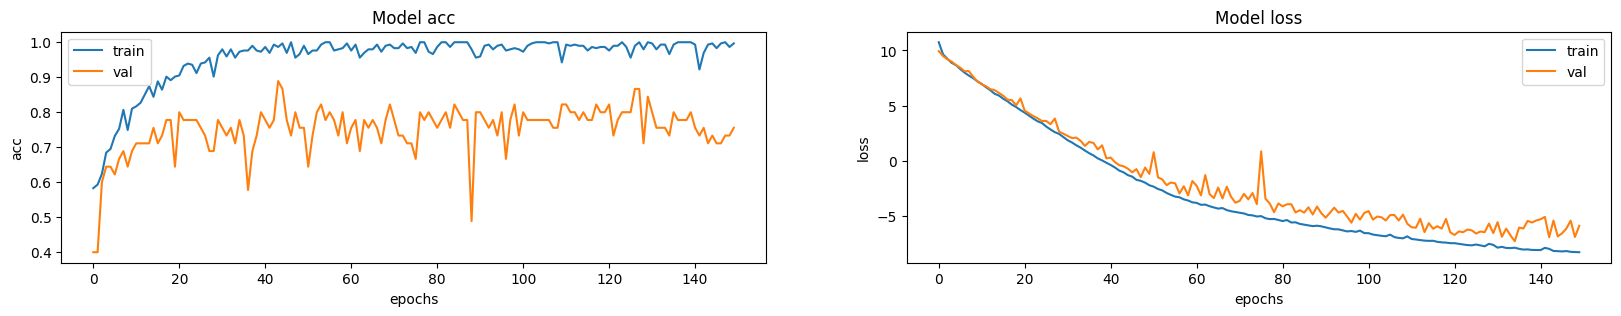

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, metric in enumerate(["acc", "loss"]):
    ax[i].plot(model.history.history[metric])
    ax[i].plot(model.history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

In [ ]:
# list all data in history
print(history.history.keys())

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


In [ ]:
file_history

'/content/gdrive/MyDrive/Maestria/Tesis/Bayesian_NN/Modelos_Colab/History_Modelo_Keras_Arch_3D_W4_V1_Uncertainty_V4'

In [ ]:
with open(file_history, 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

# Para leer https://stackoverflow.com/questions/41061457/keras-how-to-save-the-training-history-attribute-of-the-history-object

In [ ]:
model.evaluate(validation_dataset, verbose=2)

23/23 - 3s - loss: -6.0510e+00 - acc: 0.7556 - 3s/epoch - 122ms/step


[-6.051000118255615, 0.7555555701255798]

In [ ]:
# file_modelo2 = '/content/gdrive/MyDrive/Maestria/Tesis/Bayesian_NN/Modelos_Colab/Modelo_Keras_Arch_3D_W4_V1.h5'
print(f"Leyendo pesos del modelo: {file_modelo}")
model.load_weights(file_modelo)

In [ ]:
model.evaluate(validation_dataset, verbose=2)

In [ ]:
y_valid_estimado = model.predict(validation_dataset)

In [ ]:
y_valid_estimado

## Calculando métricas del modelo

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(
    cm, classes,
    normalize = False,
    title = 'Confusion Matrix',
    cmap = plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalizacion can be applied by setting 'normalize = True'
    """

    plt.imshow(cm,interpolation = 'nearest', cmap= cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks,classes,rotation = 45)
    plt.yticks(tick_marks,classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment = "center",
                 color = "white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")

def calcular_metricas(nombre_modelo, tipo_set, etiquetas_reales, etiquetas_estimadas, etiquetas_estimadas_prob):

    print("Tipo:",tipo_set)

    # accuracy: (tp + tn) / (p + n)
    accuracy = accuracy_score(etiquetas_reales, etiquetas_estimadas)
    print('Accuracy: %f' % accuracy)
    # precision tp / (tp + fp)
    precision = precision_score(etiquetas_reales, etiquetas_estimadas)
    print('Precision: %f' % precision)
    # recall: tp / (tp + fn)
    recall = recall_score(etiquetas_reales, etiquetas_estimadas)
    print('Recall: %f' % recall)
    # f1: 2 tp / (2 tp + fp + fn)
    f1 = f1_score(etiquetas_reales, etiquetas_estimadas)
    print('F1 score: %f' % f1)

    # kappa
    kappa = cohen_kappa_score(etiquetas_reales, etiquetas_estimadas)
    print('Cohens kappa: %f' % kappa)
    # ROC AUC
    auc = roc_auc_score(etiquetas_reales, etiquetas_estimadas_prob)
    print('ROC AUC: %f' % auc)
    # IoU
    iou = tf.keras.metrics.IoU(num_classes=2, target_class_ids=[1])
    iou.update_state(etiquetas_reales, etiquetas_estimadas, sample_weight=None)
    iou = iou.result().numpy()
    # FBeta-Score
    beta = 2
    b2 = beta ** 2
    f_beta_score = (1 + b2) * (precision * recall) / (precision * b2 + recall)

    # confusion matrix
    matrix = confusion_matrix(etiquetas_reales, etiquetas_estimadas)
    print(matrix)

    # TP; FP; TN; FN
    TP = matrix[1][1]
    FP = matrix[0][1]
    TN = matrix[0][0]
    FN = matrix[1][0]


    df_modelo = pd.DataFrame(
        {"nombre_modelo" : [nombre_modelo],
        "tipo_set" : [tipo_set],
        "accuracy" : [accuracy],
        "precision" : [precision],
        "recall": [recall],
        "f1": [f1],
        "Cohens kappa": [kappa],
        "ROC AUC": [auc],
        "IoU": [iou],
        "FBetaScore": [f_beta_score]
        }
    )

    return df_modelo, matrix


In [ ]:
if reading_cts_tf == False:
  print("Dataset seguimiento modelo con datasets_iteration2")
  p_train_dataset = datasets_iteration2(x_train, train_df)
else:
  print("Dataset seguimiento modelo con lectura repetitiva de los CTs por batches")
  p_train_dataset = datasets_iteration(train_df) # Para poder sacar el cálculo y las etiquetas

# p_test_dataset = datasets_iteration(test_df)
# p_validation_dataset = datasets_iteration(valid_df)

prueba_shuffle = datasets_iteration(valid_df.iloc[[25,26,27]], True)
prueba_shuffle

prueba_shuffle2 = datasets_iteration(valid_df.iloc[[25,26,27]])
prueba_shuffle2

In [ ]:
etiquetas_shuffle = np.concatenate([y for x, y in prueba_shuffle], axis=0)
etiquetas_shuffle

In [ ]:
etiquetas_shuffle = np.concatenate([y for x, y in prueba_shuffle2], axis=0)
etiquetas_shuffle

In [ ]:
y_train = train_df['Label']
y_test = test_df['Label']
y_valid = valid_df['Label']


In [ ]:
# Ajustando probabilidades para los datos. Se apunta a la probabilidad de 1 (positiva).
print("Train")
yhat_probs_train = model.predict(p_train_dataset, verbose=0)
print("Test")
yhat_probs_test = model.predict(test_dataset, verbose=0)
print("Valid")
yhat_probs_valid = model.predict(validation_dataset, verbose=0)


# Calculamos las clases
print("Clases")
yhat_classes_train = ((yhat_probs_train > 0.5)+0).ravel()
yhat_classes_test = ((yhat_probs_test > 0.5)+0).ravel()
yhat_classes_valid = ((yhat_probs_valid > 0.5)+0).ravel()

print("Shapes")
print("Shape train", yhat_classes_train.shape)
print("Shape test", yhat_classes_test.shape)
print("Shape valid", yhat_classes_valid.shape)

In [ ]:
# Lo dejamos como 1d array
# yhat_probs_train = yhat_probs_train[:, 0]
# yhat_probs_test = yhat_probs_test[:, 0]
# yhat_probs_valid = yhat_probs_valid[:, 0]

#yhat_classes_train = yhat_classes_train[:, 0]
#yhat_classes_test = yhat_classes_test[:, 0]
#yhat_classes_valid = yhat_classes_valid[:, 0]

In [ ]:
metricas_train, cm_train = calcular_metricas(nombre_modelo = version_modelo,
                    tipo_set="Training",
                    etiquetas_reales=y_train,
                    etiquetas_estimadas=yhat_classes_train,
                    etiquetas_estimadas_prob=yhat_probs_train)

metricas_valid, cm_valid = calcular_metricas(nombre_modelo = version_modelo,
                    tipo_set="Validacion",
                    etiquetas_reales=y_valid,
                    etiquetas_estimadas=yhat_classes_valid,
                    etiquetas_estimadas_prob=yhat_probs_valid)

metricas_test, cm_test = calcular_metricas(nombre_modelo = version_modelo,
                    tipo_set="Test",
                    etiquetas_reales=y_test,
                    etiquetas_estimadas=yhat_classes_test,
                    etiquetas_estimadas_prob=yhat_probs_test)


resumen_modelo = pd.concat([metricas_train,metricas_valid,metricas_test]).reset_index(drop = True)
resumen_modelo

In [ ]:
r'{}{}'.format(ruta_modelo,f"{version_modelo}.xlsx")

In [ ]:
resumen_modelo.to_excel(r'{}{}'.format(ruta_modelo,f"{version_modelo}.xlsx"), index = False)

In [ ]:
etiquetas_vf = ['No Signos Neumonia','Signos Neumonia']

In [ ]:
plot_confusion_matrix(cm = cm_train, classes = etiquetas_vf,title = "Confusion Matrix Neumonía")

In [ ]:
plot_confusion_matrix(cm = cm_valid, classes = etiquetas_vf,title = "Confusion Matrix Neumonía")

In [ ]:
plot_confusion_matrix(cm = cm_test, classes = etiquetas_vf,title = "Confusion Matrix Neumonía")

In [ ]:
valid_df['Label'].value_counts()